---
# MATH 434/534 Case Study: Image Deblurring
---

<img src="jetplane.tif" width=384> | <img src="jetplaneblurred.tif" width=384>
:----------------:|:------------------------:
Original image    | Blurred image


Images captured by cameras are often blurry; for example, the lens may not be focused, or the cameraman’s hand could be shaky. One important problem in [digital image processing](https://en.wikipedia.org/wiki/Digital_image_processing) is thus to _deblur_ an image. A simple idea is to model the blurred image as an output of a linear map (i.e., multiplication by a matrix) on the original image. Under that assumption, the process of deblurring essentially involves solving a system of linear equations.

## Images as matrices

For simplicity, we will only consider greyscale images. Such an image can be regarded as a two-dimensional array, where each entry corresponds to the intensity of a pixel in the image. Typical values for intensity are integers from 0 to 255, with 0 meaning black and 255 meaning white. Dividing by 255, these 256 different integer values can be scaled to be between 0 and 1.  See the JuliaImages documentation on the [0-to-1 intensity scale](https://juliaimages.org/latest/quickstart/#The-0-to-1-intensity-scale-1).

---
### Exercise 1

1. Install and load the `Julia` package [`Images`](https://github.com/JuliaImages/Images.jl).
2. Load the `cameraman.tif` image into a variable called `img`. What is `size(img)`?
3. Convert `img` to a two-dimensional array of `Float64` values between 0 and 1 called `Xtrue`. Verify that the entries of `255*Xtrue` are indeed integers between 0 and 255.
4. Convert `Xtrue` back to an image using the `Gray` function.

In [2]:
#2
using Images
img = load("cameraman.tif")
size(img)

(512, 512)

In [3]:
#3
Xtrue = convert(Array{Float64}, img)

512×512 Array{Float64,2}:
 0.611765  0.615686  0.627451  0.623529  …  0.596078  0.596078  0.596078
 0.611765  0.615686  0.623529  0.619608     0.596078  0.596078  0.596078
 0.619608  0.615686  0.611765  0.611765     0.596078  0.596078  0.596078
 0.627451  0.615686  0.603922  0.603922     0.6       0.596078  0.596078
 0.619608  0.615686  0.611765  0.611765     0.6       0.596078  0.596078
 0.611765  0.615686  0.623529  0.623529  …  0.6       0.6       0.6     
 0.619608  0.615686  0.611765  0.611765     0.6       0.6       0.6     
 0.627451  0.615686  0.603922  0.603922     0.6       0.6       0.6     
 0.619608  0.607843  0.6       0.6          0.596078  0.596078  0.596078
 0.611765  0.603922  0.6       0.6          0.592157  0.596078  0.596078
 0.607843  0.603922  0.603922  0.6       …  0.588235  0.596078  0.596078
 0.607843  0.607843  0.607843  0.603922     0.592157  0.596078  0.596078
 0.607843  0.603922  0.6       0.6          0.592157  0.588235  0.588235
 ⋮                       

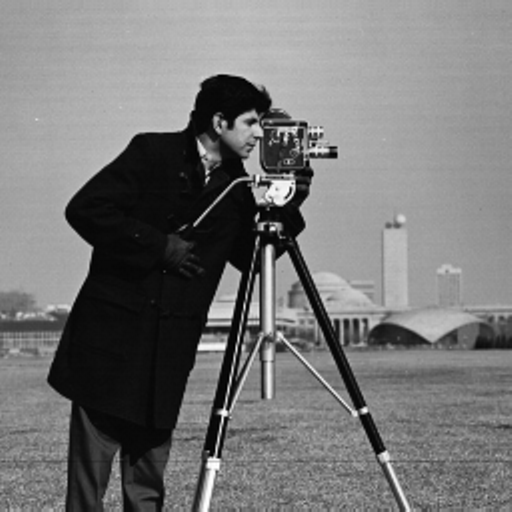

In [4]:
#4
img_gray = Gray.(Xtrue)
display(img_gray)

---

## The blurring process

Let $X_\mathrm{true} \in \mathbb{R}^{m \times n}$  denote the true image and $Y \in \mathbb{R}^{m \times n}$ denote the blurred image. We assume the blurring process is described by 

$$
Y = A_c X_\mathrm{true} A_r^T + \varepsilon
$$

for some blurring matrices $A_c \in \mathbb{R}^{m \times m}$ and $A_r \in \mathbb{R}^{n \times n}$, and a matrix $\varepsilon$ that captures measurement errors. We will assume that each entry $\varepsilon_{ij}$ of the matrix $\varepsilon$ is [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution) with mean 0 and variance $\tau^2$, for some $\tau > 0$, which can be written as $\varepsilon_{ij} \sim \mathcal{N}(0, \tau^2)$.

---
### Exercise 2

1. The **probability density function** of the normal distribution $\mathcal{N}(\mu, \sigma^2)$ with mean $\mu$ and variance $\sigma^2$ is defined as

   $$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right).$$

   Write a `Julia` function `f(x; μ=0.0, σ=1.0)` having named parameters `μ` and `σ` with default values `0.0` and `1.0`, respectively.

2. Install and load the `Julia` package [`Plots`](https://github.com/JuliaPlots/Plots.jl).

3. Use your `Julia` function `f` to plot $f(x)$ using various choices of $\mu$ and $\sigma$.

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242
┌ Warning: Module JSON with build ID 12635818623504 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
└ @ Base loading.jl:1017


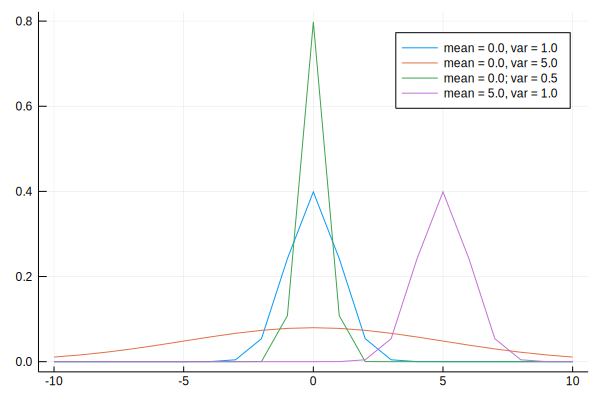

In [5]:
using Plots

f(x; μ=0.0, σ=1.0) = ((1/sqrt(2*π*σ^2)) * exp(-(x-μ)^2/(2*σ^2)))

function getY(μ, σ)
    y = zeros(21)
    for x in -10:10
        y[x+11] = f(x, μ = μ, σ = σ)
    end
    return y    
end

plot( -10:10, getY(0.0, 1.0), label="mean = 0.0, var = 1.0")
plot!(-10:10, getY(0.0, 5.0), label="mean = 0.0, var = 5.0")
plot!(-10:10, getY(0.0, 0.5), label="mean = 0.0; var = 0.5")
plot!(-10:10, getY(5.0, 1.0), label="mean = 5.0, var = 1.0")

---

## The blurring matrices $A_c$ and $A_r$

To understand the action of the blurring matrices, imagine you are taking a picture of a point source, i.e., a picture $X_0$ that is nonzero only at entry $(i,j)$ and zero everywhere else. Then $A_cX_0$ can only have nonzero entries along the $j$th column. Thus, the matrix $A_c$ describes how blurring occurs in the vertical direction. Similarly, $A_r$ describes how blurring occurs in the horizontal direction, and we see that $X_0A_r^T$ can only have nonzero entries along the $i$th row.

The $j$th column of a matrix can be extracted by multiplication on the right by the vector $e_j$, which has a single 1 at the $j$th entry, and is zero otherwise. The $j$th column of the matrix $A_c$ describes the blurring effect on a "light source" at the $j$th position. [Gaussian blurring](https://en.wikipedia.org/wiki/Gaussian_blur) redistributes the single light source according to a Gaussian distribution. Thus, the $(i,j)$ entry of $A_c$ is given by

$$
(A_c)_{ij} = (A_c e_j)_i = f(i - j) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(i - j)^2}{2\sigma^2}\right),
$$

where $f(x)$ is the probability density function of $\mathcal{N}(0, \sigma^2)$. 

Similarly, the $i$th row of a matrix can be extracted by multiplication on the left by the vector $e_i^T$, which has a single 1 at the $i$th entry, and is zero otherwise. Thus, the $(i,j)$ entry of $A_r^T$ is also given by

$$
(A_r^T)_{ij} = (e_i^T A_r^T)_j = f(i - j) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(i - j)^2}{2\sigma^2}\right).
$$

Notice that both $A_r$ and $A_c$ are symmetric since $f(i - j) = f(j - i)$. Thus, $(A_r)_{ij} = f(i - j)$ as well.

---
### Exercise 3

1. Write a function `blurmatrix(n, σ)` that returns an $n \times n$ blurring matrix $A$, defined by $A_{ij} = f(i-j)$. Use your `f` function from Exercise 2 and [array comprehensions](https://docs.julialang.org/en/v1/manual/arrays/#Comprehensions-1) to code this function in one line: `blurmatrix(n, σ) = ...`.

2. Using $\sigma = 4$, create the matrices $A_c$ and $A_r$. Display the three images $A_c X_\mathrm{true}$, $X_\mathrm{true} A_r^T$, and $A_c X_\mathrm{true} A_r^T$. What do you observe?

3. Write a function `blur(X, Ac, Ar, τ)` that returns the noisy blurred image $Y = A_cXA_r^T + \varepsilon$, where $\varepsilon_{ij} \sim \mathcal{N}(0, \tau^2)$. In `Julia`, the $\varepsilon$ matrix can be computed by `ε = τ*randn(m, n)`. Use the function `clamp01` to ensure $0 \le y_{ij} \le 1$. Use this function with `τ = 1e-4, 1e-3, 1e-2, 1e-1`. For which value of $\tau$ is the effect of noise clearly visible?

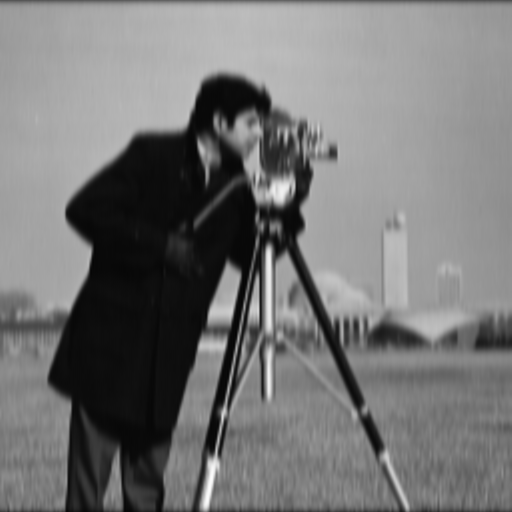

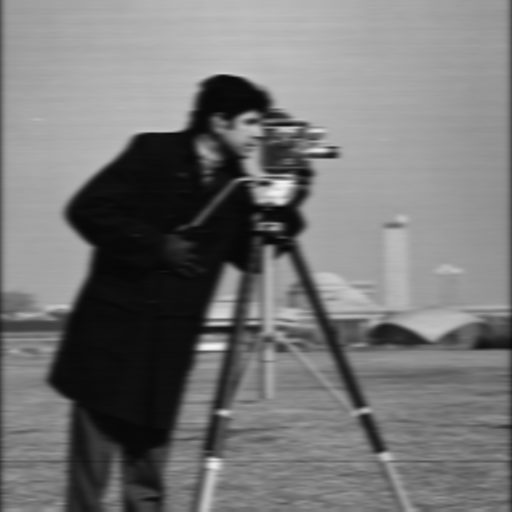

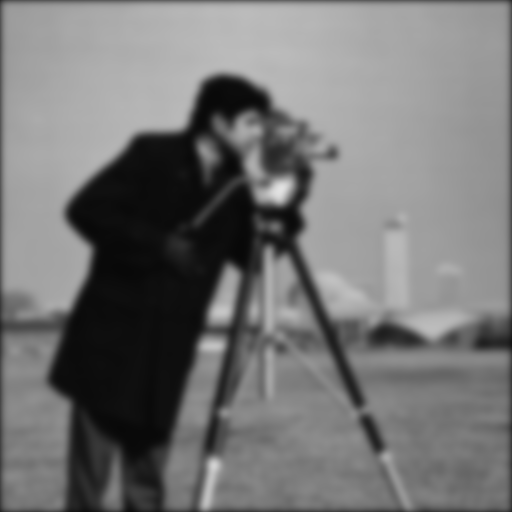

In [6]:
f(x, σ; μ=0.0) = ((1/sqrt(2*π*σ^2)) * exp(-(x-μ)^2/(2*σ^2)))
#1
blurmatrix(n, σ) = [f(i - j, σ)  for i=1:n, j=1:n]

A = blurmatrix(size(Xtrue,1), 4)
img_gray = Gray.(A*Xtrue)
display(img_gray)
img_gray = Gray.(Xtrue*A)
display(img_gray)
img_gray = Gray.(A*Xtrue*A)
display(img_gray)

### 2.

From Observing the pictures generated from these Matricies heres what i found:

$A_cX_{true}$: Blurs the image vertically.

$X_{true}A_r^T$: Blurs the image horizonatally.

$A_cX_{true}A_r^T$: Blurs the image both vertically and horizonatally.

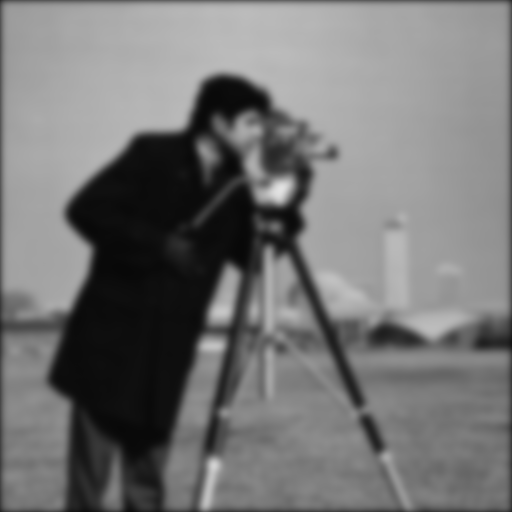

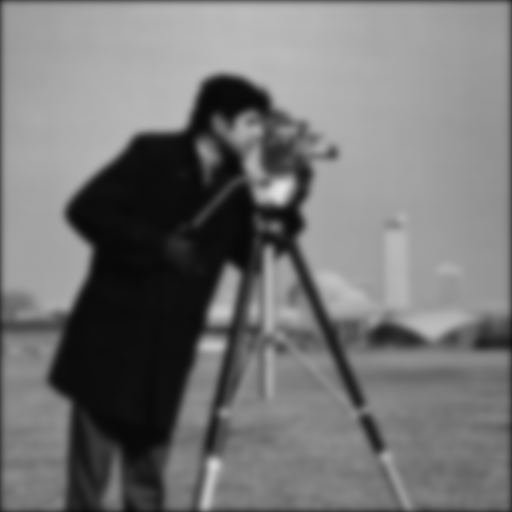

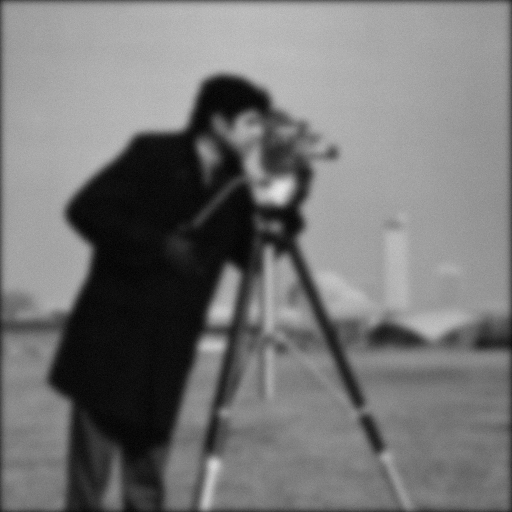

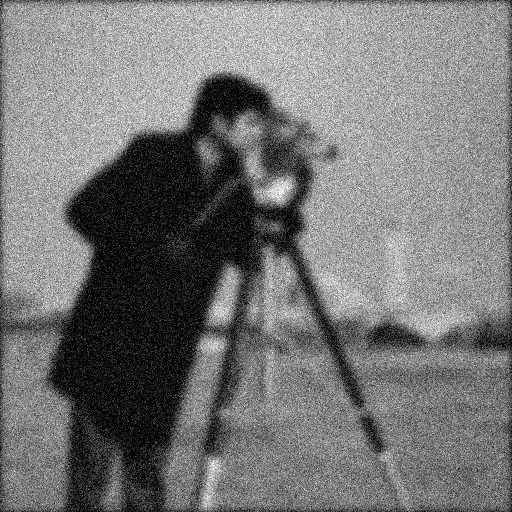

In [7]:
blur(X, Ac, Ar, τ) = Ac*X*Ar + τ*randn(size(Ac,1), size(Ac,2))

for e=[1e-4, 1e-3, 1e-2, 1e-1]
    Y = blur(Xtrue, A, A, e)
    img_gray = Gray.(Y)
    display(img_gray)
end

### 3.
In these images the only ones that seem to be noticably affected are the values of $1e-2$ and $1e-1$. Especially the last addition of noise makes the picture almost sand like and unrecognizable.

---

## A simple deblurring approach

In the noiseless case, we have $Y = A_c X A_r^T$, which implies that 

$$X = A_c^{-1} Y A_r^{-T}.$$ 

---
### Exercise 4

1. Write a function `deblur(Y, Ac, Ar)` that implements the above simple approach to deblur an image $Y$. Do not use the `inv` function; use the `\` and `/` functions instead. Use `clamp01` to ensure that $0 \le x_{ij} \le 1$. 

2. Experiment with your function on both noisy and noiseless blurred images $Y$. Experiment with different amounts of blurring and noise. For which values of $\sigma$ and $\tau$ does this method produce good results?

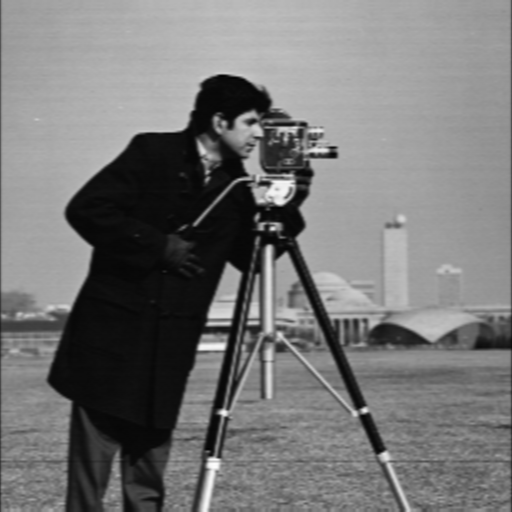

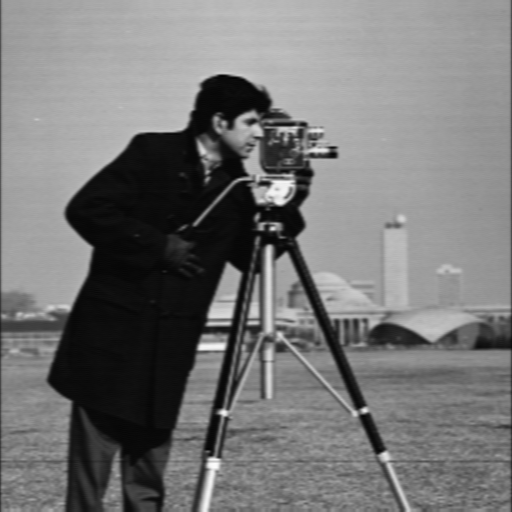

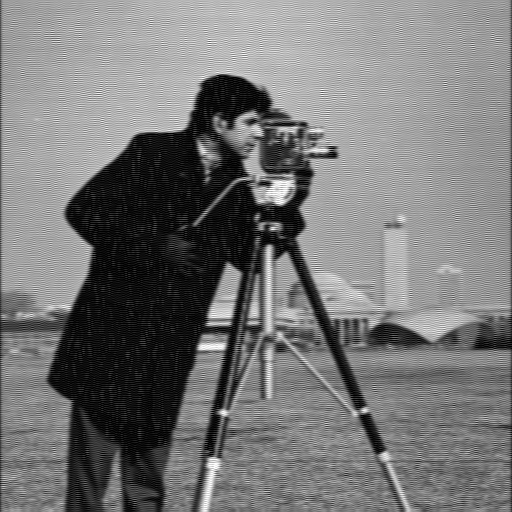

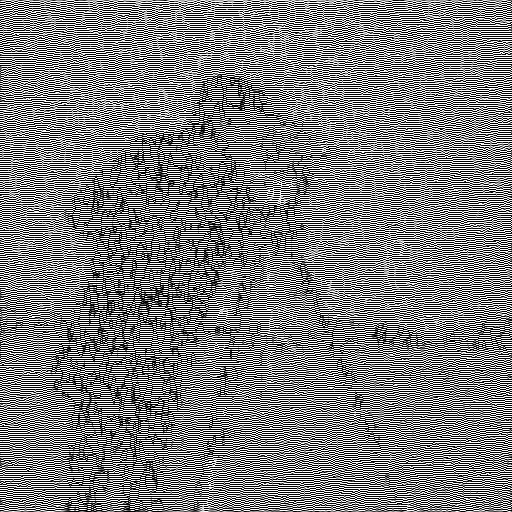

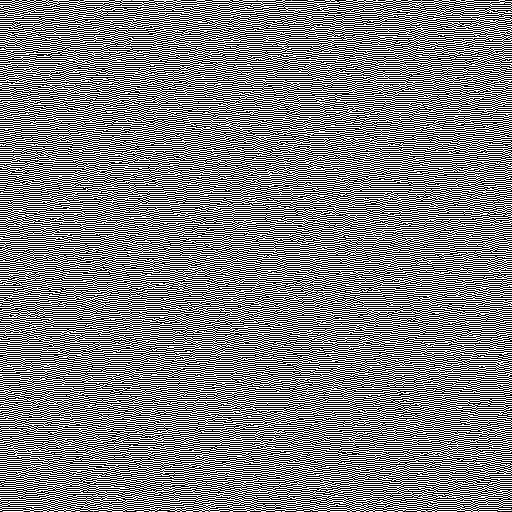

In [8]:
n = size(A,1)

blur(X, Ac, Ar, τ) = Ac*X*Ar + τ*randn(size(Ac,1), size(Ac,2))

deblur(Y, Ac, Ar) = Y\Ac\Ar
i = 1
for e=[0, 1e-4, 1e-3, 1e-2, 1e-1]
    A = blurmatrix(size(Xtrue,1), i)
    Y = blur(Xtrue, A, A, e)
    X = deblur(Y, A, A)
    #img_grayblur = Gray.(Y)
    img_grayunblur = Gray.(X)
    #display(img_grayblur)
    display(img_grayunblur)
    i = i + 0.1
end

## 2.
This function is only effective at the very small amounts of noise and blur. In my testing increasing the noise above $1e-3$ makes the picture completely unrecognizable. The unbluring only had an effect at the most minimal levels of bluring also. For any value of 𝜎 higher than 2.0 the picture seemed to be completely scrammbled and simply became a gray screen. This method doesnt seam effective to unblur any image that isnt almost completely clear to begin with.

---

## Tikhonov regularization

The simple approach we explored in Exercise 3 is very sensitive to noise and blurring. [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) can be an effective way to perform image debluring that is less sensitive. Instead of solving $A_cXA_r^T = Y$ for the matrix $X$, we seek $X$ that minimizes

$$
\left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2,
$$

for some $\alpha \ge 0$. Recall that $$\|A\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n a_{ij}^2}$$ is the Frobenius norm of a matrix $A \in \mathbb{R}^{m \times n}$. Setting $\alpha = 0$ gives us our previous simple approach. Larger $\alpha$ means that $X$ should not have entries that are too large; this makes sense since we require $0 \leq x_{ij} \leq 1$.

We can find the $X$ that gives us the minimum value of $\left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2$ using the **singular value decomposition**.

---

## The Singular Value Decompositon (SVD)

For a full treatment of the singular value decomposition, see Chapter 4 in _Fundamentals of Matrix Computations_ by Watkins. For this case study, we only need to know the following theorem.

> ### Theorem: (SVD Theorem)
>
> Let $A \in \mathbb{R}^{m \times n}$ be a nonzero matrix with rank $r$. Then $A$ can be expressed as a product
>
> $$A = U \Sigma V^T,$$
>
> where $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal, and $\Sigma \in \mathbb{R}^{m \times n}$ is a rectangular "diagonal" matrix
>
> $$
  \Sigma = 
  \begin{bmatrix}
  \sigma_1 \\
  & \sigma_2 \\
  && \ddots \\
  &&& \sigma_r \\
  &&&& 0 \\
  &&&&& \ddots
  \end{bmatrix}
  \qquad
  \sigma_1 \ge \sigma_2 \ge \cdots \ge \sigma_r > 0.
  $$
  
The entries $\sigma_1, \ldots, \sigma_r$ of $\Sigma$ are called the **singular values** of $A$.

---
### Exercise 5

1. Read the documentation on the `Julia` function `svd` and use it to compute the SVD of the matrix
   
   $$
   A = 
   \left[
   \begin{array}{rrr}
   -2 & -5 & 4 \\
   2 & -7 & 4 \\
   1 & 4 & -3 \\
   \end{array}
   \right].
   $$
   
   Verify that $A = U \Sigma V^T$. Looking at the singular values, what is the rank of $A$?
   
2. Recall that a matrix $U$ is **orthogonal** if it is square and $U^TU = UU^T = I$. Verify that the matrices $U$ and $V$ computed in part 1 are orthogonal.

In [9]:
#1
A = [-2. -5. 4.; 2. -7. 4.; 1. 4. -3.]

3×3 Array{Float64,2}:
 -2.0  -5.0   4.0
  2.0  -7.0   4.0
  1.0   4.0  -3.0

In [10]:
using LinearAlgebra
F = svd(A)

SVD{Float64,Float64,Array{Float64,2}}([-0.5613108699897282 0.6380848920430549 0.52704627669473; -0.7018566774710812 -0.7044757576937221 0.1054092553389459; 0.4385513784274651 -0.31074358781519407 0.8432740427115677], [11.416322197450171, 3.1092744304751516, 2.373756674888699e-16], [0.013792512224289455 0.8298431353025431 -0.5578262609431249; -0.9635253993424207 0.1601439511094914 0.214412499041146; -0.2672612419124244 -0.5345224838248486 -0.8017837257372731])

In [11]:
F.U*Diagonal(F.S)*(F.Vt)

3×3 Array{Float64,2}:
 -2.0  -5.0   4.0
  2.0  -7.0   4.0
  1.0   4.0  -3.0

In [12]:
F.S

3-element Array{Float64,1}:
 11.416322197450171    
  3.1092744304751516   
  2.373756674888699e-16

The $rank(A) = 2$ based on the fact that there are two nonzero singular values. 

In [13]:
#2
F.U

3×3 Array{Float64,2}:
 -0.561311   0.638085  0.527046
 -0.701857  -0.704476  0.105409
  0.438551  -0.310744  0.843274

$U$ is a 3x3 matrix and therefore is square.

In [14]:
F.U'*F.U

3×3 Array{Float64,2}:
  1.0          -1.11022e-16  -2.22045e-16
 -1.11022e-16   1.0           1.66533e-16
 -2.22045e-16   1.66533e-16   1.0        

In [15]:
F.U*F.U'

3×3 Array{Float64,2}:
  1.0           2.84495e-16  -1.66533e-16
  2.84495e-16   1.0          -9.71445e-17
 -1.66533e-16  -9.71445e-17   1.0        

In [16]:
F.V

3×3 Adjoint{Float64,Array{Float64,2}}:
  0.0137925  -0.963525  -0.267261
  0.829843    0.160144  -0.534522
 -0.557826    0.214412  -0.801784

$V$ is a 3x3 matrix and therefore is square.

In [17]:
F.V'*F.V

3×3 Array{Float64,2}:
  1.0          -5.55112e-17  -5.55112e-17
 -5.55112e-17   1.0           2.77556e-17
 -5.55112e-17   2.77556e-17   1.0        

The matrices $U$ and $V$ are therefore orthogonal

---
### Exercise 6

1. An important property about orthogonal matrices is that multiplication by them does not change the Euclidean length of vectors; that is, if $U \in \mathbb{R}^{n \times n}$ is orthogonal, then $\|Ux\|_2 = \|x\|_2$, for all vectors $x \in \mathbb{R}^n$. Prove this by using the formula $\|x\|_2^2 = x^Tx$.

2. Let $M \in \mathbb{R}^{m \times n}$. Prove that if $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal, then $\|UM\|_F = \|M\|_F$ and $\|MV\|_F = \|M\|_F$.

matrix * matrix (if orthog) the 2norm and forb norm do not change length

#1

If $\|x\|_2^2 = x^Tx$, 

then, $\|Ux\|_2^2 = U(x^Tx)$

   = $(Ux)^T (Ux)$
                  
   = $U^Tx^TUx$
                  
   = $x^Tx$
                  
   = $\|x\|_2^2$
                  
Thus, $\|Ux\|_2 = \|x\|_2$

#2

If $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal and $M \in \mathbb{R}^{m \times n}$: Then,

$$
\|UM\|_F = (UM)^T(UM) = M^TU^TUM = M^TM = \|M\|_F
$$

$$
\|MV\|_F = (MV)(MV)^T = MVV^TM^T = MM^T = \|M\|_F
$$
Therefore,
$$
\|MV\|_F = \|UM\|_F = \|M\|_F
$$

---
### Exercise 7

1. Let $A_c = U_c S_c V_c^T$ and $A_r = U_r S_r V_r^T$ be the singular value decompositions of the blurring matrices $A_c$ and $A_r$, respectively. Prove that
   
   $$
   \left\|A_c X A_r^T - Y\right\|_F^2 + \alpha \left\|X\right\|_F^2 = 
   \left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2,
   $$
   
   where $\bar{X} = V_c^T X V_r$ and $\bar{Y} = U_c^T Y U_r$.
   
2. Let $s_{ij} = \sigma_i(A_c)\sigma_j(A_r)$, where $\sigma_i(A_c)$ is the $i$th singular value of $A_c$ and $\sigma_j(A_r)$ is the $j$th singular value of $A_r$. Prove that
   
   $$
   \left\|S_c \bar{X} S_r - \bar{Y}\right\|_F^2 + \alpha \left\|\bar{X}\right\|_F^2 = 
   \sum_{ij} \left( \left(s_{ij}^2 + \alpha\right) \bar{x}_{ij}^2 - 2s_{ij}\bar{x}_{ij}\bar{y}_{ij} + \bar{y}_{ij}^2\right),
   $$
   
   where $\bar{x}_{ij}$ and $\bar{y}_{ij}$ are the $(i,j)$ entries of the matrices $\bar{X}$ and $\bar{Y}$, respectively.
   
3. The sum in part 2 can be minimized by finding $\bar{x}_{ij}$ that minimizes $\left(s_{ij}^2 + \alpha\right) \bar{x}_{ij}^2 - 2s_{ij}\bar{x}_{ij}\bar{y}_{ij} + \bar{y}_{ij}^2$. To this end, consider the function
   
   $$
   f(x) = (s^2 + \alpha)x^2 - 2syx + y^2,
   $$
   
   where $\alpha > 0$ and $s, y \in \mathbb{R}$ are considered as constants. Determine the $x$ that minimizes $f(x)$ by solving $f'(x) = 0$ and checking that $f''(x) > 0$. Then give the formula for the optimal $\bar{x}_{ij}$.
   
4. Prove that $X = V_c \bar{X} V_r^T$.


1. Since $U_c, U_r, V_c, V_r$ are all orthogonal, $||X||=||\bar{X}||$ therefore $\alpha||X||=\alpha||\bar{X}||$

if we expand $A_c$ and $A_r$ we get $||A_cXA_r^T-Y|| = ||U_c S_c V_c^T X V_r S_r^TU_r^T-Y|| = ||U_cS_c\bar{X}S_r^TU_r^T-Y||$ if we multiply on the left by $U_c^T$ and on the right by $U_r$ we get $||S_c\bar{X}S_r^T-U_c^TYU_r||$ since $S_r$ is symmetric and because $U_r$ and $U_c^T$ are orhogonal this is the same as $||S_c\bar{X}S_r-\bar{Y}||=||U_cS_c\bar{X}S_r^TU_r^T-Y|| = ||A_c X A_r^T - Y|| $

therefore $||A_cXA_r^T-Y||_F^2+\alpha||X||_F^2=||S_c\bar{X}S_r-\bar{Y}||_F^2+\alpha||\bar{X}||_F^2$

2. for the matrix $S_c\bar{X}S_r$ any given entry $[i,j]$ is equal to $\sigma_i(A_c)\bar{x}_{ij}\sigma_j(A_r)=s_{ij}\bar{x}_{ij}$

therefore $||S_c\bar{X}S_r-\bar{Y}||_F^2+\alpha||\bar{X}||_F^2=\sum_{ij}(s_{ij}\bar{x}_{ij}-\bar{y}_{ij})^2+\sum_{ij}\alpha(\bar{x}_{ij})^2 = \sum_{ij}((s_{ij}\bar{x}_{ij}-\bar{y}_{ij})^2+\alpha(\bar{x}_{ij})^2)=\sum_{ij}(s_{ij}^2\bar{x}_{ij}^2-2s_{ij}\bar{x}_{ij}\bar{y}_{ij}+\bar{y}_{ij}^2+\alpha\bar{x}_{ij}^2)=\sum_{ij}((s_{ij}^2+\alpha)\bar{x}_{ij}^2-2s_{ij}\bar{x}_{ij}\bar{y}_{ij}+\bar{y}_{ij}^2)$

3. $f'(x)=2(s^2+\alpha)x-2sy$ the solution to $f'(x)=0$ is $x= \frac{sy}{s^2+\alpha},$ $f''(x)=2(s^2+\alpha)$ which is always greater than $0$ since $\alpha>0.$ the formula for the optimal $\bar{x}_{ij}$ is $\bar{x}_{ij}=\frac{s_{ij}\bar{y}_{ij}}{s_{ij}^2+\alpha}$

4. since $\bar{X}=V_c^TXV_r, V_c\bar{X}V_r^T=V_cV_c^TXV_rV_r^T$ since $V_c$ and $V_r$ are orthogonal $V_cV_c^TXV_rV_r^T=X$

---
### Exercise 8

1. Write a function `tikdeblur(Y, Ac, Ar; α=1e-4)` that implements the approach outlined in Exercise 7 to deblur an image $Y$. Use `clamp01` to ensure that $0 \le x_{ij} \le 1$. 

2. Experiment with your function on both noisy and noiseless blurred images $Y$. Experiment with different amounts of blurring and noise. For which values of $\sigma$ and $\tau$ does this method produce good results? Use your function with `α = 1e-6, ..., 1e-1` and `α = 0.0`. Is `α = 1e-4` a good default value, or would you recommend a different default value for $\alpha$?

'shouldn't need for loops'

In [18]:
using LinearAlgebra;

In [19]:
function tikdeblur(Y, Ac, Ar; α=1e-4)
    n = size(Y,1);
    y = convert(Array{Float64}, Y);
    sAc = svd(Ac);
    sAr = svd(Ar);
    s = sAc.S*transpose(sAr.S);
    ybar = transpose(sAc.U)*y*sAr.U;
    xbar = [ s[i,j]*ybar[i,j]/(s[i,j]^2+α) for i=1:n, j=1:n ];
    return sAc.V*xbar*transpose(sAr.V);
end

tikdeblur (generic function with 1 method)

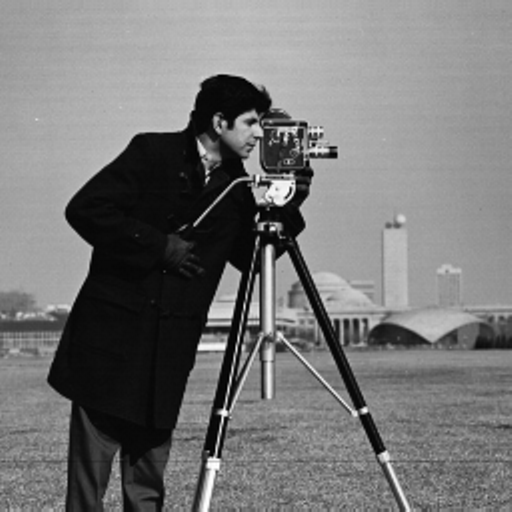

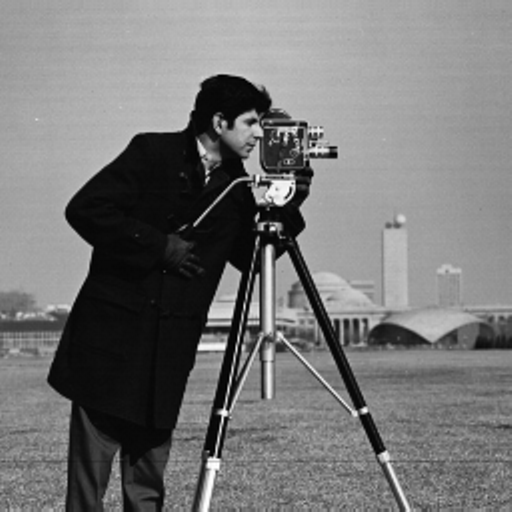

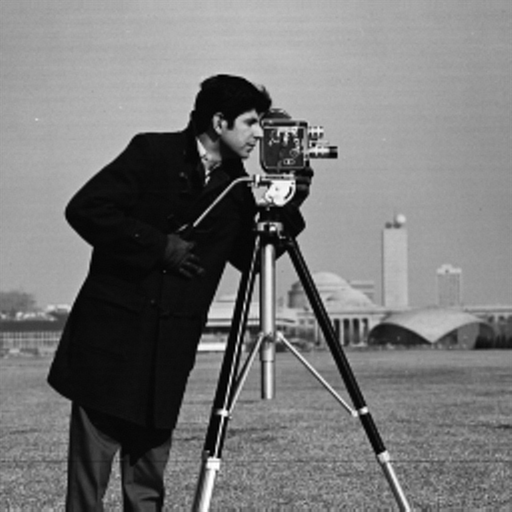

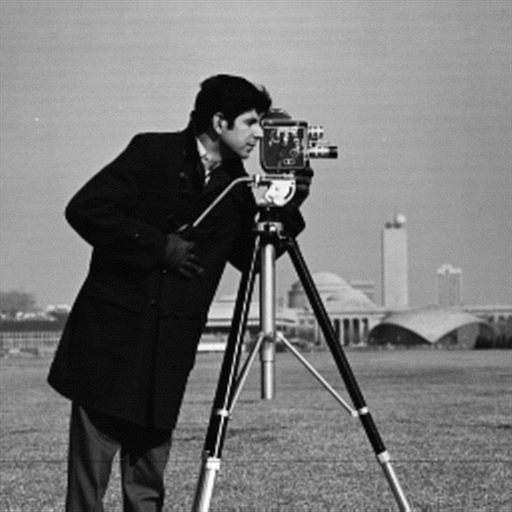

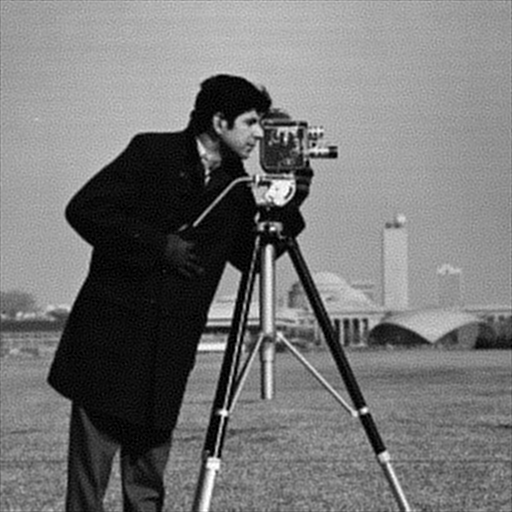

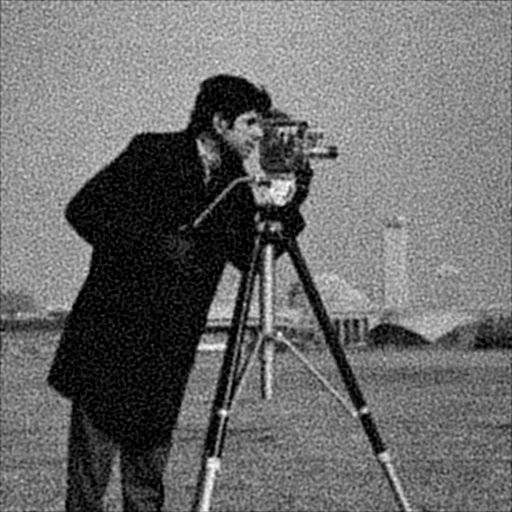

In [20]:
i = 1
for e=[0, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1]
    A = blurmatrix(size(Xtrue,1), i);
    Y = blur(Xtrue, A, A, e);
    X = tikdeblur(Y, A, A; α=e);
    img_grayunblur = Gray.(X);
    display(img_grayunblur);
    i = i + 0.1;
end

---
### Exercise 9

Use your `tikdeblur` function to read the sign in the image `blurrysign.tif`.

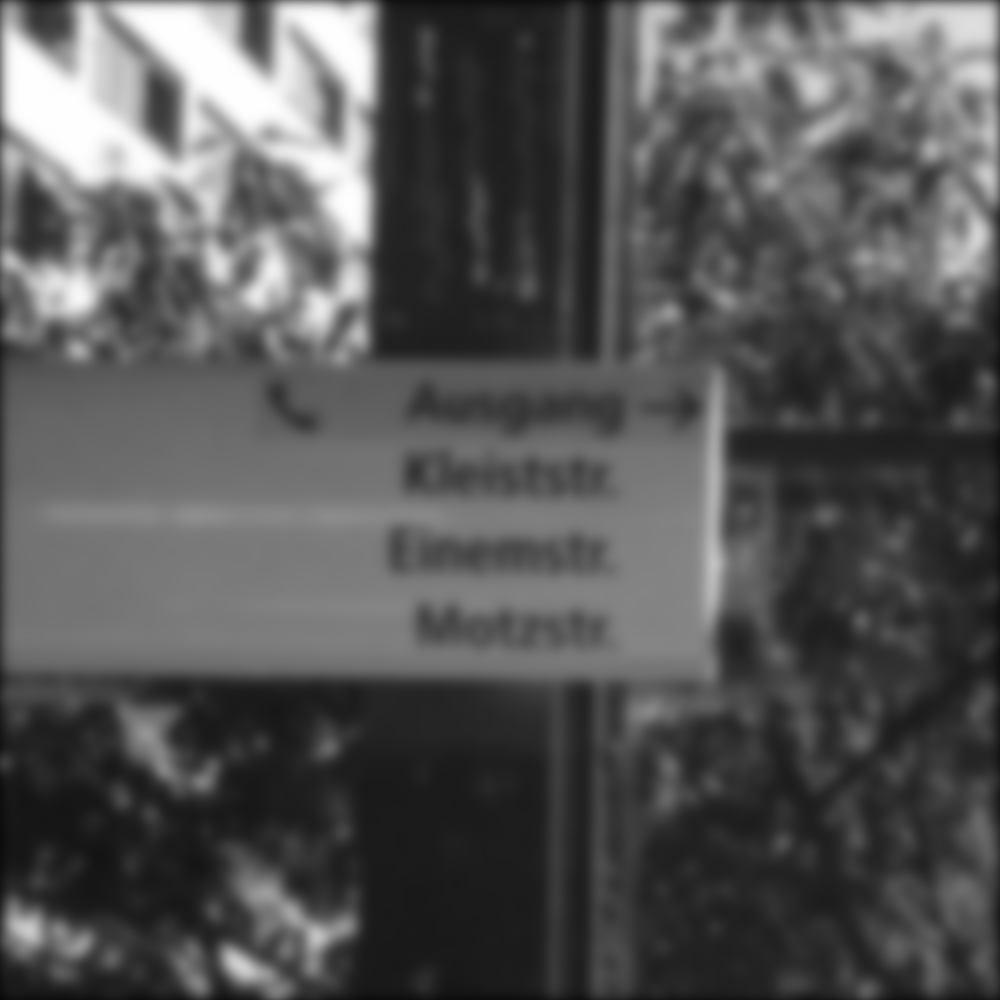

In [21]:
blurrysign = load("blurrysign.tif")

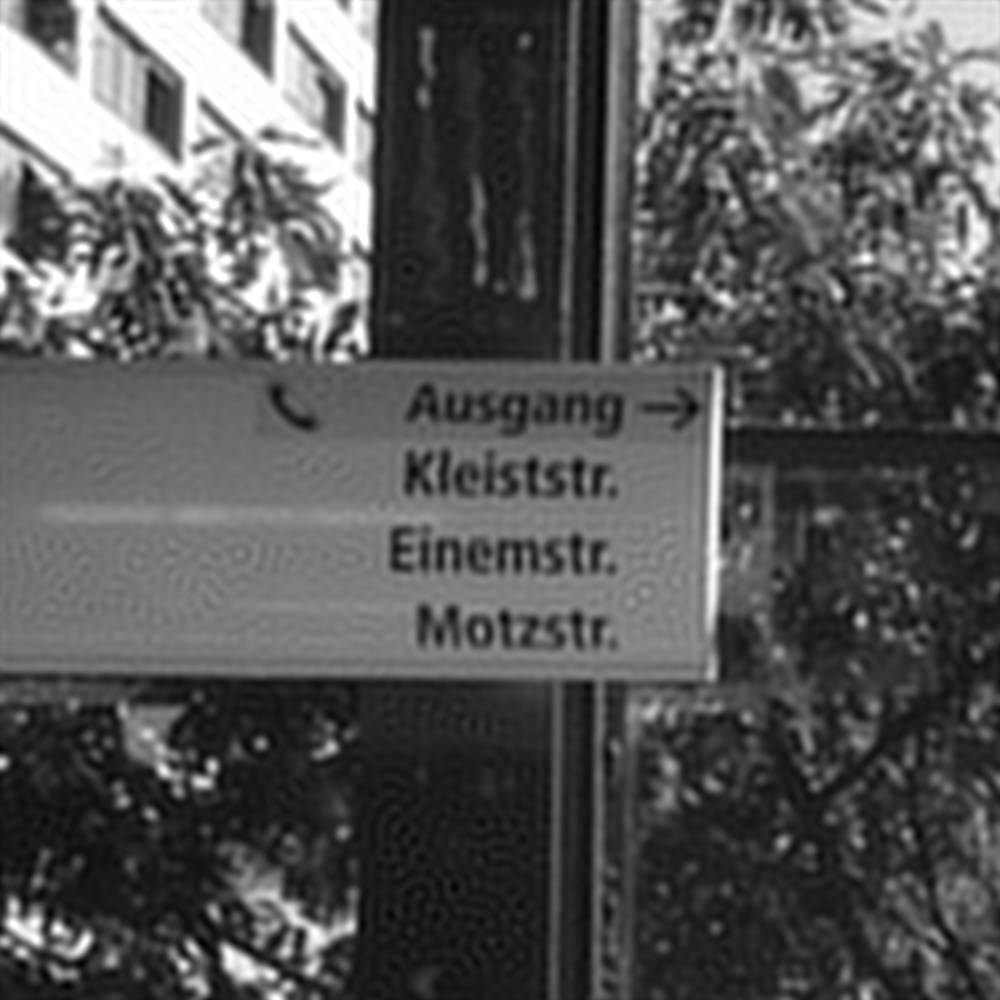

In [22]:
blurrysignX = convert(Array{Float64}, blurrysign);

e = 1e-4
i = 7
A = blurmatrix(size(blurrysignX,1), i);
X = tikdeblur(blurrysignX, A, A; α=e);
img_grayunblur = Gray.(X);
display(img_grayunblur);

---